In [16]:
# Library imports
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

In [17]:
def normalize_minmax(data):
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    return data

def prob(betas, data, i):
    rows, cols = data.shape
    u = betas[0] + np.dot(betas[1:], data[i][:cols - 1].T)
    return 1 / (1 + math.exp(-u))

def log_loss(betas, data):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data, i)
        loss += cli * math.log(pi) + (1 - cli) * math.log(1 - pi)
    loss *= -1 / rows
    return loss

def accuracy(betas, data, threshold):
    rows, cols = data.shape
    acc = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data, i)
        acc += cli * pi + (1 - cli) * (1 - pi) >= threshold
    acc /= rows
    return acc

def iterate(betas, data_train, data_test, epochs, learning_rate):
    metrics = {
        'loss_train': [log_loss(betas, data_train)],
        'loss_test': [log_loss(betas, data_test)],
        'acc_train': [accuracy(betas, data_train, 0.5)],
        'acc_test': [accuracy(betas, data_test, 0.5)]
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            u = betas[0] + np.dot(betas[1:], data_train[i][:cols - 1].T)
            temp = prob(betas, data_train, i) * (data_train[i][cols - 1] * math.exp(-u) + data_train[i][cols - 1] - 1)
            dbetas[0] += temp
            dbetas[1:] += data_train[i][:cols - 1] * temp
        dbetas *= -1 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(log_loss(betas, data_train))
        metrics['loss_test'].append(log_loss(betas, data_test))
        metrics['acc_train'].append(accuracy(betas, data_train, 0.5))
        metrics['acc_test'].append(accuracy(betas, data_test, 0.5))
    return metrics

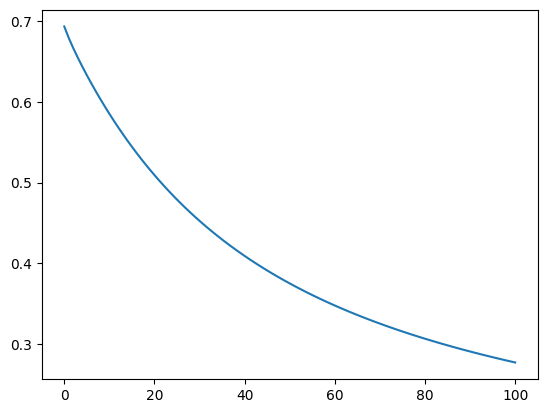

In [18]:
data = pd.read_csv('logreg_data.csv').to_numpy()
data = normalize_minmax(data)
train, test = train_test_split(data, test_size=0.1, shuffle=True)

betas = np.zeros(data.shape[1])

eps = 100
lr = 1
metrics = iterate(betas, train, test, eps, lr)

plt.plot(range(eps + 1), metrics['loss_train'])
plt.show()

In [19]:
cars = pd.read_csv('car_data.csv')
cars = cars[['Gender', 'Age', 'AnnualSalary', 'Purchased']]
cars = cars.transform(lambda x: (x == 'Male') * 1 if x.name == 'Gender' else x)
cars = normalize_minmax(cars.to_numpy())
train, test = train_test_split(cars, test_size=0.1, shuffle=True)

In [20]:
betas = np.zeros(cars.shape[1])

eps = 250
lr = 5
metrics = iterate(betas, train, test, eps, lr)

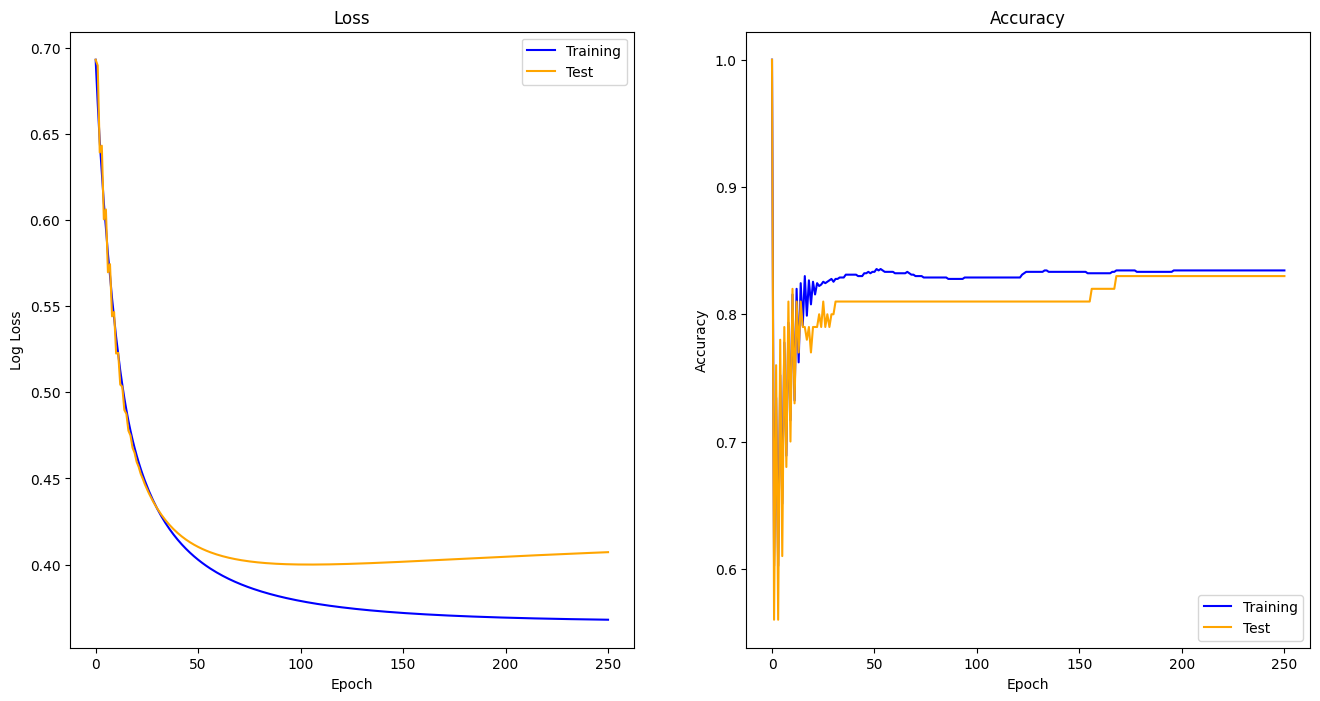

In [23]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(range(eps + 1), metrics['acc_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['acc_test'], c='orange', label='Test')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [22]:
mpl.rcParams.update(mpl.rcParamsDefault)